In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from lib.creditcard_fraud_dataset import get_train_test_dfs, X_COLS
from lib.cs_eval import evaluate_pred

# 2. Subsampling

Another problem is that there are much more negatives than positives in the dataset (i.e. more non-fradulent than fraudulent transactions). By **using less negative samples**, we can balance the dataset again.

## 2.1 Train

### 2.1.1 Inspect dataset

In [3]:
df_train, df_test = get_train_test_dfs()

<AxesSubplot:xlabel='Class', ylabel='count'>

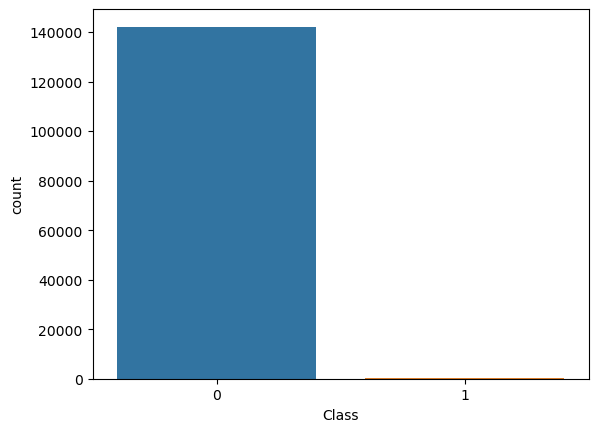

In [4]:
sns.countplot(x='Class', data=df_train)

Indeed, you can see in the bar chart above that the number of fraudulent transactions is much lower than the number of non-fraudulent transactions.

### 2.1.2 Run training *without* balancing

First, we'll run a training with the original (unbalanced) dataset.

In [5]:
X_train = df_train[X_COLS]
y_train = df_train['Class']

In [7]:
# Create a logistic regression classifier
clf_unbalanced = LogisticRegression(max_iter=500)

# Train it on X_train and y_train
clf_unbalanced.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### 2.1.3 Run training *with* balancing

Next, we will balance the dataset by using **the same number of negatives and positives**. More specifically, we will **subsample the number of negatives** until it is equal to the number of positives.

To start, let's first compute the number of fraudulent transactions.

In [8]:
# Since the fraudulent transactions have class 1, we can count
# them by summing the "Class" column
num_fraud = df_train['Class'].sum()

To balance the dataset, we  will take the following steps:

1. Store all *fraudulent* transactions in the variable `X_fraud`
2. Store all *non-fraudulent* transactions in the variable `X_no_fraud`
3. *Subsample* `X_no_fraud` so that it has the same amount of rows as `X_fraud`
4. Combine `X_fraud` and the subsampled `X_no_fraud` into the variable `X_balanced`

Remember that `X_train` is a pandas DataFrame. On any DataFrame, you can call the method [`sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to select a random set of rows in the DataFrame.

In [9]:
# Create boolean mask to select all fraudulent rows
is_fraud = df_train['Class'] == 1

# Select all fraudulent rows
X_fraud = X_train[is_fraud]

In [10]:
# Create boolean mask to select all non-fraudulent rows
no_fraud = df_train['Class'] == 0

# Select all non-fraudulent rows
X_no_fraud = X_train[no_fraud]

# Subsample to get the same number non-fraudulent as fraudulent
X_no_fraud = X_no_fraud.sample(n=num_fraud)

In [11]:
# Concatenate X_fraud and X_no_fraud
X_balanced = pd.concat([X_fraud, X_no_fraud])

# Create y_balanced by concatenating array of ones and zeros
y_balanced = np.concatenate([np.ones(len(X_fraud)),
                             np.zeros(len(X_no_fraud))])

In [12]:
# Train the classifier
clf_balanced = LogisticRegression(max_iter=500)
clf_balanced.fit(X_balanced, y_balanced)

LogisticRegression(max_iter=500)

## 2.2 Evaluate

In [13]:
X_test = df_test[X_COLS]
y_test = df_test['Class']

# Compute predictions of both classifiers
y_pred_unbalanced = clf_unbalanced.predict(X_test)
y_pred_balanced = clf_balanced.predict(X_test)

# Get the transaction amounts
amounts = df_test['Amount']

# Compute metrics for each classifier
eval_metrics_unbalanced = evaluate_pred(y_test, y_pred_unbalanced, amounts)
eval_metrics_balanced   = evaluate_pred(y_test, y_pred_balanced,   amounts)

In [14]:
df = pd.DataFrame([
    {
        'Method': 'Unbalanced',
        **eval_metrics_unbalanced
    },
    {
        'Method': 'Balanced',
        **eval_metrics_balanced
    },
])

In [15]:
df

,Method,Cost Precision,Cost Recall,TP Amount,FP Amount,FN Amount,Net Recovered Amount
0,Unbalanced,0.997766,0.514306,16075.45,36.0,15181.12,858.33
1,Balanced,0.747885,0.890032,27819.35,9378.0,3437.22,15004.13


<AxesSubplot:xlabel='Method', ylabel='Cost Recall'>

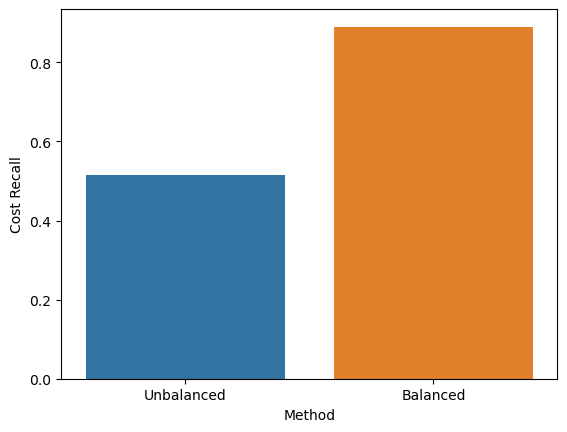

In [16]:
sns.barplot(data=df, x='Method', y='Cost Recall')

<AxesSubplot:xlabel='Method', ylabel='Cost Precision'>

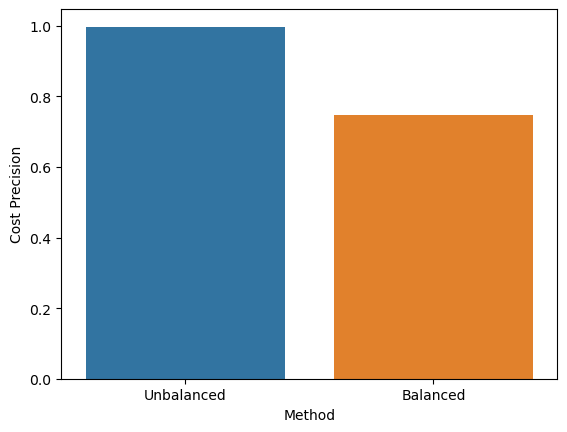

In [17]:
sns.barplot(data=df, x='Method', y='Cost Precision')